# Importing libraries and processing the data

In [118]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from power.ml_ops.cross_val import get_folds, train_test_split, get_X_y_seq
from power.ml_ops.model import init_baseline_keras, compile_model, train_model #, initialize_model

# tensforflow
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import Lambda

In [111]:
df = pd.read_csv('../raw_data/1980-2022_wind.csv')

In [112]:
df.head(2)

,Unnamed: 0.1,Unnamed: 0,local_time,electricity,wind_speed,source
0,0,315532800000,1980-01-01 01:00:00+01:00,0.150,5.739,data/wind_data/1980_wind.csv
1,1,315536400000,1980-01-01 02:00:00+01:00,0.198,6.279,data/wind_data/1980_wind.csv


In [113]:
df = df.drop(columns=['wind_speed', 'source', 'Unnamed: 0.1'])
df.electricity = df.electricity.astype(float)
df.local_time = df.local_time.apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S%z"))
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'], unit='ms').dt.tz_localize('UTC')
df.rename(columns={'Unnamed: 0': 'utc_time'}, inplace=True)
df.utc_time = pd.to_datetime(df.utc_time,utc=True)

In [123]:
wind_df = df.copy()

In [124]:
min_date = '1980-01-01 00:00:00'
max_date = '2019-12-31 23:00:00'
train = wind_df[wind_df['utc_time'] <= max_date]
test = wind_df[wind_df['utc_time'] > max_date]

In [125]:
train = train[['electricity']]
test = test[['electricity']]

# Cross validation

In [117]:
TARGET = 'electricity'
fold_length = 43800             # 5 years
fold_stride = 43800             # 5 years
train_test_ratio = 0.8          # 4 yrs/5 yrs
input_length = 168              # number of obsevations per one sequence
output_length = 24              # Day-ahead predictions
n_seq_train = 1000              # number_of_sequences_train
n_seq_val = 200                 # number_of_sequences_test
n_unit = 24                     # number of hidden units
learning_rate = 0.02
patience = 5
epochs = 50
batch_size = 32

In [33]:
def initialize_model(X_train, y_train, n_unit=24):

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()

    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(n_unit,
                          activation='tanh',
                          return_sequences = False,
                          input_shape=(X_train.shape[1],X_train.shape[2])
                          ))

    ## 1.2 - One dense layer
    model.add(layers.Dense(10, activation='relu'))

    ## 1.3 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    return model

In [126]:
def cross_validate_baseline_and_lstm():

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(train, fold_length, fold_stride)

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_val) = train_test_split(fold, train_test_ratio, input_length)

        X_train, y_train = get_X_y_seq(fold_train, n_seq_train, input_length, output_length, gap_hours=12)
        X_val, y_val = get_X_y_seq(fold_val, n_seq_val, input_length, output_length, gap_hours=12)

        # 2 - Modelling
        # =========================================

        ##### Baseline Model
        baseline_model = init_baseline_keras()
        mae_baseline = baseline_model.evaluate(X_val, y_val, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = initialize_model(X_train, y_train, n_unit=n_unit)
        model = compile_model(model, learning_rate=learning_rate)
        model, history = train_model(model,
                                     X_train,
                                     y_train,
                                     validation_split = 0.2,
                                     batch_size = batch_size,
                                     epochs = epochs)

        # Create a figure and axes object with 1 row and 2 columns
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

        # Plot training & validation MAE values
        axes[0].plot(history.history['mae'])
        axes[0].plot(history.history['val_mae'])
        axes[0].set_title('Model MAE')
        axes[0].set_ylabel('MAE')
        axes[0].set_xlabel('Epoch')
        axes[0].legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation loss values
        axes[1].plot(history.history['loss'])
        axes[1].plot(history.history['val_loss'])
        axes[1].set_title('Model Loss')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Validation'], loc='upper left')

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()

        res = model.evaluate(X_val, y_val, verbose=0)    # evaluating LSTM (metric)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model


--------------------------------------------------
MAE baseline fold n°0 = 0.17


2024-03-12 17:15:23.188843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 17:15:23.200494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 17:15:23.209542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

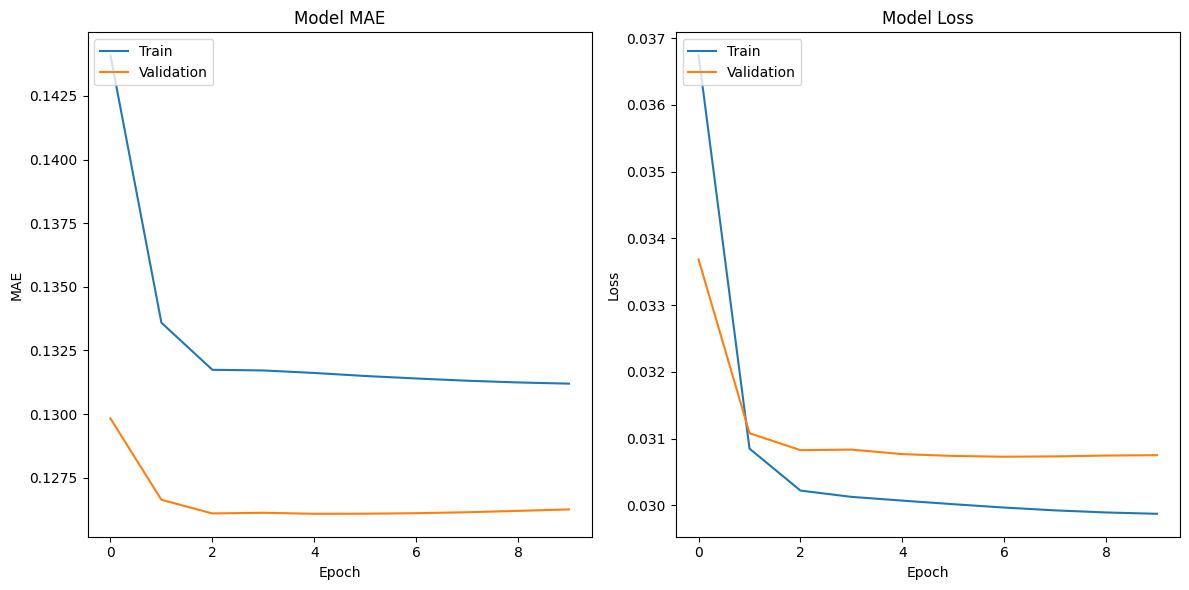

MAE LSTM fold n°0 = 0.13
improvement over baseline: 22.72 % 

--------------------------------------------------
MAE baseline fold n°1 = 0.16


2024-03-12 17:15:47.299448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 17:15:47.315536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 17:15:47.325192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

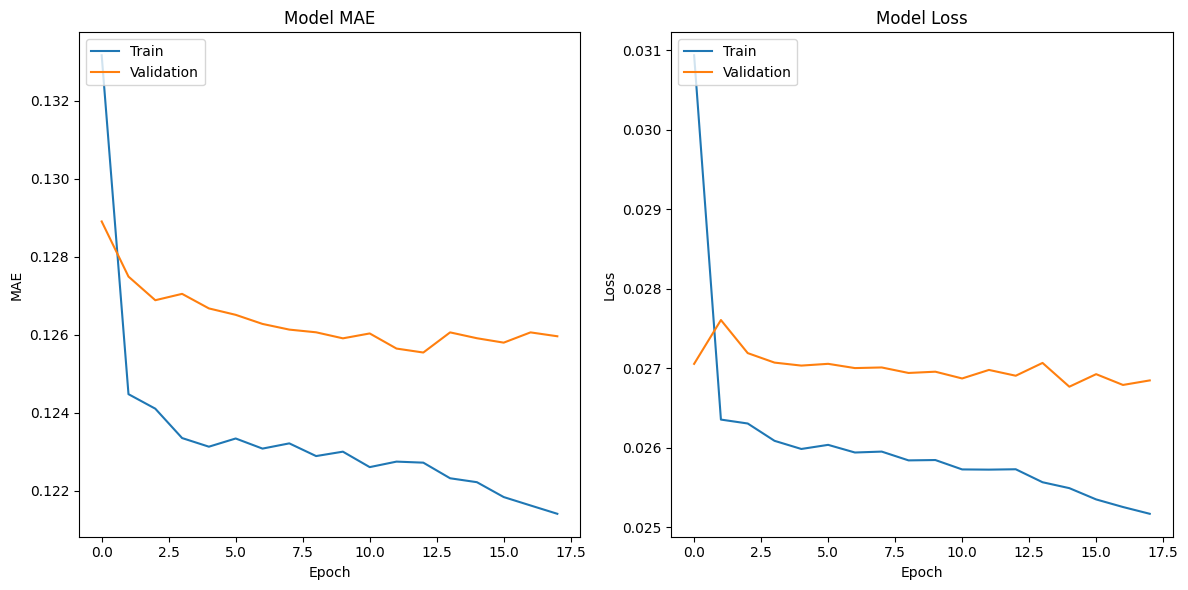

MAE LSTM fold n°1 = 0.12
improvement over baseline: 25.47 % 

--------------------------------------------------
MAE baseline fold n°2 = 0.21


2024-03-12 17:16:17.211054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 17:16:17.217092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 17:16:17.222093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

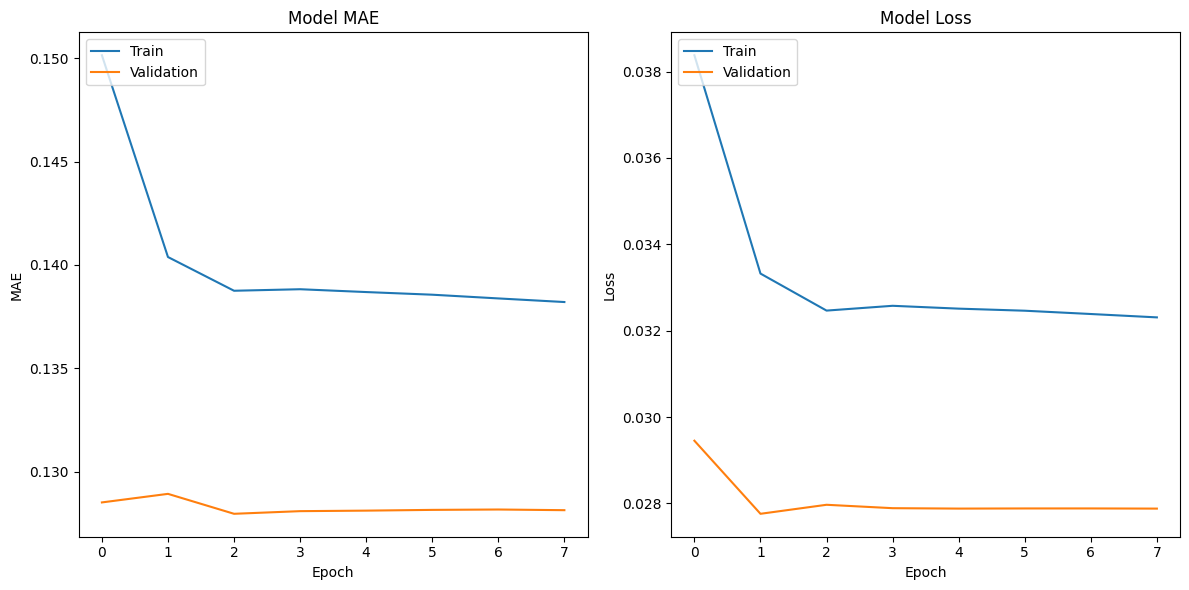

MAE LSTM fold n°2 = 0.16
improvement over baseline: 26.39 % 

--------------------------------------------------
MAE baseline fold n°3 = 0.16


2024-03-12 17:16:37.017933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 17:16:37.025049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 17:16:37.031954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

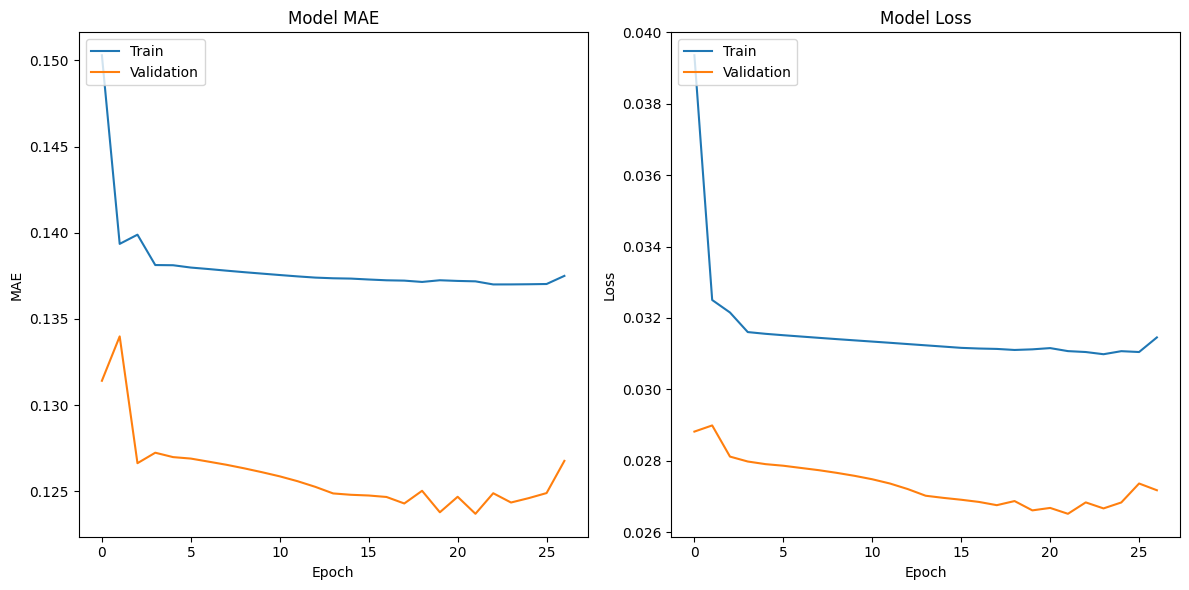

MAE LSTM fold n°3 = 0.11
improvement over baseline: 28.19 % 

--------------------------------------------------
MAE baseline fold n°4 = 0.15


2024-03-12 17:17:12.922375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 17:17:12.927607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 17:17:12.931552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

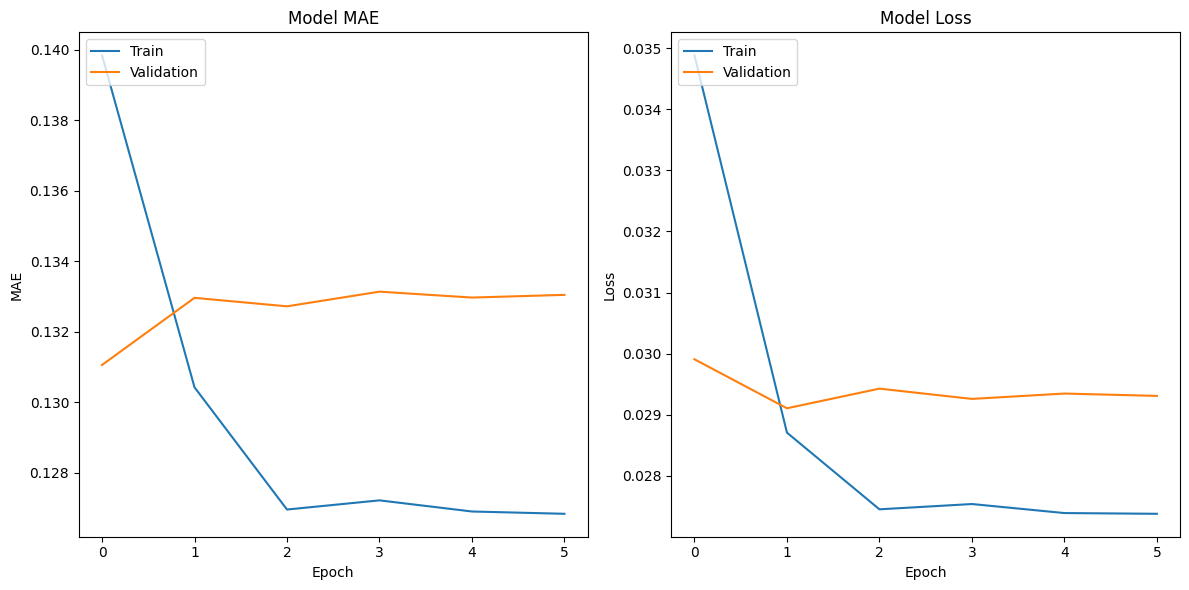

MAE LSTM fold n°4 = 0.11
improvement over baseline: 25.67 % 

--------------------------------------------------
MAE baseline fold n°5 = 0.16


2024-03-12 17:17:34.854773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 17:17:34.867296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 17:17:34.876552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

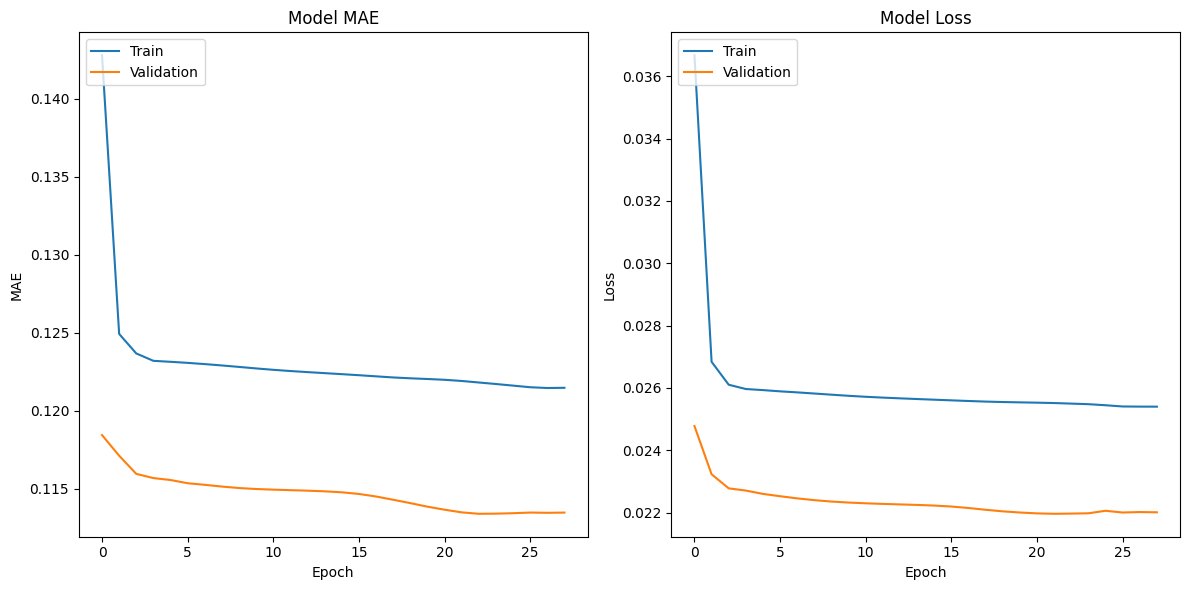

MAE LSTM fold n°5 = 0.12
improvement over baseline: 24.46 % 

--------------------------------------------------
MAE baseline fold n°6 = 0.14


2024-03-12 17:18:12.108408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 17:18:12.112407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 17:18:12.116812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

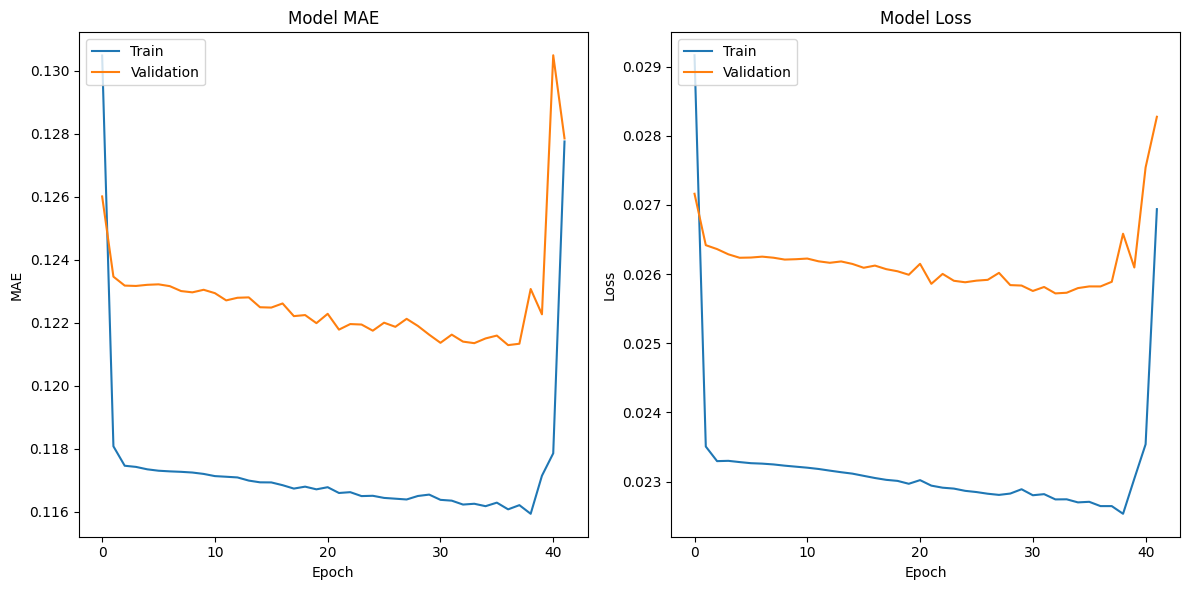

MAE LSTM fold n°6 = 0.12
improvement over baseline: 19.6 % 

--------------------------------------------------
MAE baseline fold n°7 = 0.16


2024-03-12 17:19:03.670214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 17:19:03.679631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 17:19:03.689023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

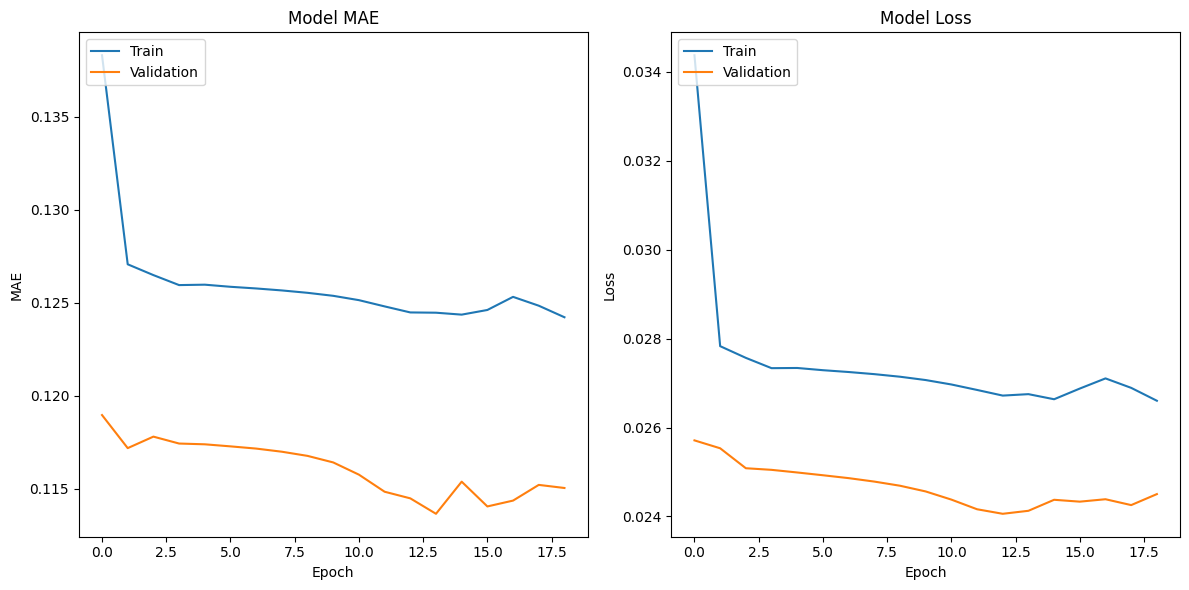

MAE LSTM fold n°7 = 0.12
improvement over baseline: 23.92 % 



In [127]:
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

In [128]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")

average percentage improvement over baseline = 25.0%


# Training the main model

In [129]:
X_train, y_train = get_X_y_seq(train, number_of_sequences=10000, input_length=48, output_length=24, gap_hours=12)

In [130]:
model = initialize_model(X_train, y_train, n_unit=n_unit)
model = compile_model(model, learning_rate=learning_rate)
model, history = train_model(model,
                                X_train,
                                y_train,
                                validation_split = 0.1,
                                batch_size = batch_size,
                                epochs = epochs)

2024-03-12 17:25:37.355175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 17:25:37.369424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 17:25:37.380555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [131]:
test = df[df['utc_time'] > max_date]

In [132]:
input_pred = '2021-05-08 12:00:00'

X_pred = test[test['utc_time'] < input_pred][-48:]

In [133]:
X_pred.head(3)

,utc_time,local_time,electricity
362436,2021-05-06 12:00:00+00:00,2021-05-06 14:00:00+02:00,0.335
362437,2021-05-06 13:00:00+00:00,2021-05-06 15:00:00+02:00,0.295
362438,2021-05-06 14:00:00+00:00,2021-05-06 16:00:00+02:00,0.253


In [134]:
X_pred = X_pred[['electricity']]

In [135]:
import tensorflow as tf

X_pred = X_pred.to_numpy()
X_pred_tf = tf.convert_to_tensor(X_pred)
X_pred_tf = tf.expand_dims(X_pred_tf, axis=0)

In [136]:
y_pred = model.predict(X_pred_tf)

2024-03-12 17:44:50.852011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-12 17:44:50.864810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-12 17:44:50.870557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step


In [137]:
y_pred[0]

array([0.15501837, 0.1600635 , 0.16589417, 0.1754543 , 0.18088628,
       0.18679312, 0.1905232 , 0.19320932, 0.20263124, 0.20856637,
       0.20303613, 0.19339359, 0.19057414, 0.19005807, 0.19404039,
       0.19630978, 0.20073742, 0.20460673, 0.20841534, 0.21285164,
       0.21300742, 0.21463972, 0.2187736 , 0.21444303], dtype=float32)

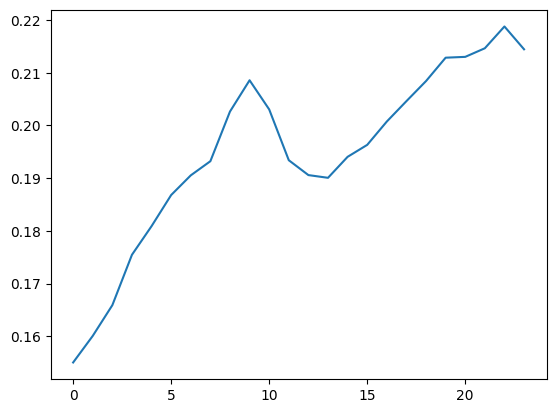

In [138]:
plt.plot(y_pred[0])

In [146]:
y_true = test[test['utc_time'] >= input_pred][12:36]

In [147]:
y_true = y_true[['electricity']]

In [148]:
y_true = y_true.to_numpy()
y_true = y_true.reshape(1,24)[0]
y_true

array([0.343, 0.329, 0.317, 0.328, 0.259, 0.172, 0.14 , 0.183, 0.205,
       0.278, 0.349, 0.323, 0.281, 0.266, 0.245, 0.225, 0.272, 0.382,
       0.493, 0.503, 0.464, 0.452, 0.448, 0.449])

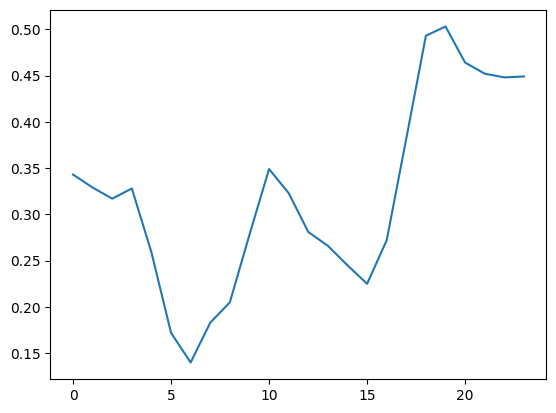

In [149]:
plt.plot(y_true)

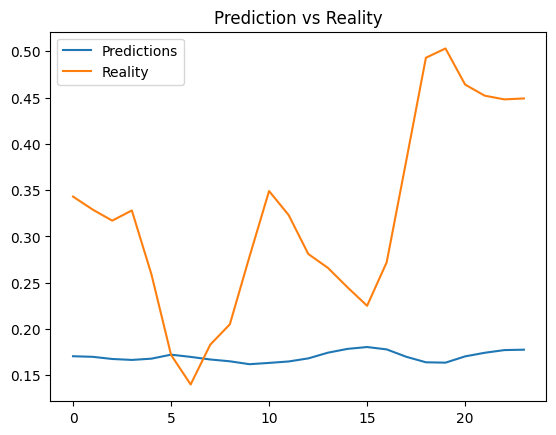

In [110]:
plt.plot(y_pred[0], label='Predictions')
plt.plot(y_true, label='Reality')

plt.title('Prediction vs Reality')
plt.legend()

# Show the plot
plt.show()